In [12]:
import pandas as pd
import numpy as np
import nba_api 
import random
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.8,7.27)})

#Importing various packages and nba_api

In [2]:
from nba_api.stats.endpoints import (leaguegamefinder, boxscoreadvancedv2,boxscoretraditionalv2,
                                 boxscoreplayertrackv2, boxscorescoringv2, boxscoreusagev2)
#Importing required nba_api endpoints to access stats

In [3]:
season_games = leaguegamefinder.LeagueGameFinder(league_id_nullable = '00', season_nullable = '2019-20',
                season_type_nullable = 'Regular Season').get_data_frames()[0]['GAME_ID'].unique()
#Creating a list of '19-20 regular season games to iterate through

In [ ]:
trad_keep = ['GAME_ID','TEAM_ID','PLAYER_ID','PLAYER_NAME','FGM','FGA','FG3M','FG3A','FTM','FTA',
           'OREB','DREB','REB','STL','BLK','TO','PF','PTS','PLUS_MINUS']
scoring_keep = ['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'PLAYER_NAME', 'PCT_FGA_2PT',
       'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR', 'PCT_PTS_3PT',
       'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT',
       'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM', 'PCT_UAST_3PM',
       'PCT_AST_FGM', 'PCT_UAST_FGM']
adv_keep = ['GAME_ID','TEAM_ID',  'PLAYER_ID','PLAYER_NAME','E_OFF_RATING','OFF_RATING', 
            'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT',
       'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE']
#Making lists of columns from each endpoint that I want to keep for further analysis


bigdf = pd.DataFrame()
#Initializing big dataframe that each game will append to

for game in season_games:
    trad = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id = game).get_data_frames()[0][trad_keep]
    track = boxscoreplayertrackv2.BoxScorePlayerTrackV2(game_id = game).get_data_frames()[0]
    scoring = boxscorescoringv2.BoxScoreScoringV2(game_id = game).get_data_frames()[0][scoring_keep]
    adv = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id = game).get_data_frames()[0][adv_keep]
    df = pd.merge(track, trad, on = ['PLAYER_ID', 'GAME_ID','TEAM_ID','PLAYER_NAME'])
    df = pd.merge(df, scoring, on = ['PLAYER_ID', 'GAME_ID','TEAM_ID','PLAYER_NAME'])
    df = pd.merge(df, adv, on = ['PLAYER_ID', 'GAME_ID','TEAM_ID','PLAYER_NAME'])
    bigdf = bigdf.append(df)
    #Collecting stats from various endpoints for each game, then appending them to the big dataframe

bigdf = bigdf.reset_index(drop = True)
bigdf['UAST_2PM'] = (bigdf['PCT_UAST_2PM'] * (bigdf['FGM'] - bigdf['FG3M']))
bigdf['AST_2PM'] = (bigdf['PCT_AST_2PM'] * (bigdf['FGM'] - bigdf['FG3M']))
bigdf['UAST_3PM'] = (bigdf['PCT_UAST_3PM'] * bigdf['FG3M'])
bigdf['AST_3PM'] = (bigdf['PCT_AST_3PM'] * bigdf['FG3M'])
bigdf['AST_FGM'] = (bigdf['PCT_AST_FGM'] * bigdf['FGM'])
bigdf['GP'] = 1
#Creating a few new metrics for each game, to be aggregated later

In [ ]:
bigdf['MP'] = bigdf['MIN'].apply(lambda x: (int(x.split(':')[1])/60) + (int(x.split(':')[0])))
bigdf.to_csv('boxscores_2019.csv', index = False)

In [4]:
bigdf = pd.read_csv('boxscores_2019.csv')
bigdf['MP'] = bigdf['MP'].round(1)
bigdf = bigdf.rename(columns={'PLAYER_NAME': 'NAME'})
agg_df = bigdf.groupby(['PLAYER_ID', 'NAME'])[['UAST_2PM','AST_2PM','UAST_3PM','AST_3PM', 
                    'AST_FGM', 'FGM','GP', 'PTS', 'AST', 'FTA', 'FGA', 'MP', 'POSS',
                    'TCHS','PASS', 'SAST','FTAST', 'TO']].agg(sum).reset_index()
#Using previously created boxscores file, aggregating from game-level to player-level.


agg_df['total_2pm'] = (agg_df['AST_2PM'] + agg_df['UAST_2PM'])
agg_df['total_3pm'] = (agg_df['AST_3PM'] + agg_df['UAST_3PM'])
agg_df['pct_2pm_ast'] = (agg_df['AST_2PM'] / agg_df['total_2pm'])
agg_df['pct_3pm_ast'] = (agg_df['AST_3PM'] / agg_df['total_3pm'])
agg_df['pct_ast'] = (agg_df['AST_FGM'] / agg_df['FGM'])
agg_df['PPG'] = (agg_df['PTS'] / agg_df['GP']).round(1)
agg_df['PTS/36'] = (agg_df['PTS'] / (agg_df['MP'] / 36)).round(1)
agg_df['PTS/100p'] = (agg_df['PTS'] / (agg_df['POSS'] / 100)).round(1)
agg_df['APG'] = (agg_df['AST'] / agg_df['GP']).round(1)
agg_df['AST/36'] = (agg_df['AST'] / (agg_df['MP'] / 36)).round(1)
agg_df['AST/100p'] = (agg_df['AST'] / (agg_df['POSS'] / 100)).round(1)
agg_df['TS%'] = (agg_df['PTS'] / (2* (agg_df['FGA'] + (0.44*agg_df['FTA'])))).round(3)
agg_df['FGM/100p'] = (agg_df['FGM'] / (agg_df['POSS'] / 100)).round(1)
agg_df['shot_creator_maker'] = (agg_df['PTS/100p'] / agg_df['pct_ast']).round(1)
agg_df['AST/PASS'] = (agg_df['AST'] / agg_df['PASS']).round(4)
agg_df['AST/TCHS'] = (agg_df['AST'] / agg_df['TCHS']).round(4)
agg_df['FGA/TCHS'] = (agg_df['FGA'] / agg_df['TCHS']).round(3)
agg_df['PASS/TCHS'] = (agg_df['PASS'] / agg_df['TCHS']).round(3)
agg_df['SAST/100p'] = (agg_df['SAST'] / (agg_df['POSS'] / 100)).round(1)
agg_df['FTAST/100p'] = (agg_df['FTAST'] / (agg_df['POSS'] / 100)).round(1)
agg_df['ast_all_100p'] = (agg_df['AST/100p'] + agg_df['SAST/100p'] + agg_df['FTAST/100p']).round(1)
agg_df['ast_all'] = (agg_df['AST'] + agg_df['FTAST'] + agg_df['SAST'])
agg_df['ast_all/PASS'] = (agg_df['ast_all'] / agg_df['PASS']).round(4)
agg_df['ast_all/TCHS'] = (agg_df['ast_all'] / agg_df['TCHS']).round(3)
agg_df['SAST_FTAST/100p'] = (agg_df['SAST/100p'] + agg_df['FTAST/100p']).round(1)
agg_df['SAST_FTAST/TCHS'] = ((agg_df['SAST'] + agg_df['FTAST']) / agg_df['TCHS']).round(2)
agg_df['SAST_FTAST/PASS'] = ((agg_df['SAST'] + agg_df['FTAST']) / agg_df['PASS']).round(2)
agg_df['TO/TCHS'] = (agg_df['TO'] / agg_df['TCHS']).round(1)
agg_df['TO/PASS'] = (agg_df['TO'] / agg_df['PASS']).round(1)
agg_df['TO/100p'] = (agg_df['TO'] / (agg_df['POSS'] / 100)).round(1)
agg_df['assist_safe'] = (agg_df['ast_all_100p'] / agg_df['TO/100p']).round(1)

agg_df['pct_ast'] = pd.Series(['{0:.1f}%'.format(val * 100) for val in agg_df['pct_ast']],
                                index = agg_df.index)

#Creating many metrics here - some will get used, some will not
#Each metric is a combination of traditional metrics in one way or another

In [5]:
f_df = agg_df[agg_df['MP'] >= 500].reset_index(drop = True)
#Filtering for players who've played a minimum of 500 minutes

In [6]:
f_df = f_df.sort_values(by = 'ast_all/TCHS', ascending = False).reset_index(drop = True)
#Sorting before visualizing so that each player's index will be a ranking

pd.concat([f_df.sort_values(by = 'ast_all/TCHS', ascending = False)[['NAME','ast_all/TCHS',
    'ast_all_100p']].reset_index(drop = True).iloc[0:10],
    f_df.loc[((f_df['NAME'] == 'P.J. Tucker') | (f_df['NAME'] == 'CJ McCollum'))][['NAME','ast_all/TCHS',
    'ast_all_100p']]])
#Showing top 10 players in the ast_all/TCHS metric, along with PJ Tucker and CJ McCollum

,NAME,ast_all/TCHS,ast_all_100p
0,Ricky Rubio,0.138,15.7
1,T.J. McConnell,0.135,15.3
2,Devin Booker,0.132,10.4
3,Trae Young,0.130,14.6
4,LeBron James,0.129,16.2
5,Matthew Dellavedova,0.123,11.8
6,Rajon Rondo,0.121,14.1
7,Joe Ingles,0.119,10.6
8,Eric Bledsoe,0.117,10.7
9,Tyus Jones,0.117,12.2


In [7]:
f_df = f_df.sort_values(by = 'assist_safe', ascending = False).reset_index(drop = True)
#Sorting before visualizing so that each player's index will be a ranking

pd.concat([f_df.sort_values(by = 'assist_safe', ascending = False)[['NAME','assist_safe',
    'ast_all_100p', 'TO/100p']].reset_index(drop = True).iloc[0:10],
    f_df.loc[((f_df['NAME'] == 'P.J. Tucker') | (f_df['NAME'] == 'CJ McCollum'))][['NAME','assist_safe',
    'ast_all_100p', 'TO/100p']]])
#Showing top 10 players in the assist_safe metric, along with PJ Tucker and CJ McCollum

,NAME,assist_safe,ast_all_100p,TO/100p
0,Monte Morris,6.1,9.1,1.5
1,Tyus Jones,6.1,12.2,2.0
2,Tony Snell,5.3,4.8,0.9
3,Justin Jackson,5.2,3.1,0.6
4,Jordan McLaughlin,4.6,11.1,2.4
5,Trey Burke,4.4,8.9,2.0
6,T.J. McConnell,4.4,15.3,3.5
7,Marco Belinelli,4.3,4.3,1.0
8,Ish Smith,4.3,10.4,2.4
9,Delon Wright,4.0,8.8,2.2


In [8]:
f_df = f_df.sort_values(by = 'shot_creator_maker', ascending = False).reset_index(drop = True)
#Sorting before visualizing so that each player's index will be a ranking

pd.concat([f_df.sort_values(by = 'shot_creator_maker', ascending = False)[['NAME','shot_creator_maker',
    'PTS/100p', 'pct_ast']].reset_index(drop = True).iloc[0:10],
    f_df.loc[((f_df['NAME'] == 'P.J. Tucker') | (f_df['NAME'] == 'CJ McCollum'))][['NAME','shot_creator_maker',
    'PTS/100p', 'pct_ast']]])
#Showing top 10 players in the shot_creator_maker metric, along with PJ Tucker and CJ McCollum

,NAME,shot_creator_maker,PTS/100p,pct_ast
0,James Harden,286.4,43.9,15.3%
1,Luka Doncic,212.4,40.6,19.1%
2,Damian Lillard,207.6,37.6,18.1%
3,Trae Young,180.2,38.3,21.3%
4,Kyrie Irving,155.5,38.3,24.6%
5,Chris Paul,151.9,26.6,17.5%
6,De'Aaron Fox,147.3,30.9,21.0%
7,Derrick Rose,142.4,32.8,23.0%
8,Russell Westbrook,124.5,34.0,27.3%
9,LeBron James,119.6,34.6,28.9%


In [9]:
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 9,
        }
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if ((point['val'] == "De'Aaron Fox") | (point['val'] == 'Tyus Jones')):
             ax.text(point['x']+.1, point['y']-0.1, str(point['val']), fontdict = font)
        else:
            ax.text(point['x']+.1, point['y'], str(point['val']), fontdict = font)
#Defining label point function and customizing label font
#Manually editing De'Aaron Fox and Tyus Jones labels, as these overlap with other labels in the graph

In [14]:
labels = ['James Harden','Luka Doncic','Damian Lillard','Trae Young','Kyrie Irving','Chris Paul',
 "De'Aaron Fox",'Derrick Rose','Russell Westbrook','LeBron James', 'Monte Morris', 'Tyus Jones',
 'Tony Snell','Justin Jackson', 'P.J. Tucker','CJ McCollum']

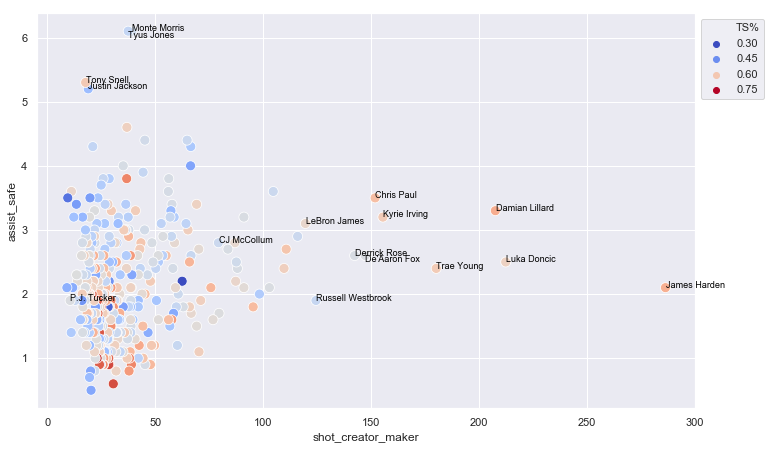

In [15]:
ax = sns.scatterplot(x = f_df['shot_creator_maker'],y =  f_df['assist_safe'], hue = f_df['TS%'],
                     s = 100,palette = 'coolwarm')
plt.legend(bbox_to_anchor=(1, 1), loc=2)

for t in ax.legend_.texts:
    t.set_text(t.get_text()[:4])
label_point(f_df.loc[f_df['NAME'].isin(labels)]['shot_creator_maker'], 
            f_df.loc[f_df['NAME'].isin(labels)]['assist_safe'],
            f_df.loc[f_df['NAME'].isin(labels)]['NAME'], plt.gca())
#Plotting shot_creator_maker vs. assist_safe with labels